# Preraring the data

## Importing packages

In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

RANDOM_SEED = 42
TORCH_GEN_SEED = 2147483647

## Loading the data

In [2]:
# Opening the dataset with names and reading its content into a variable
words = open("../names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

## Building the vocabulary and creating character-number mappings

In [3]:
# Retrieving a set of unique letters
chars = sorted(list(set(''.join(words))))

# Creating a mapping from a letter to an id
char2id = {s: i+1 for i, s in enumerate(chars)}
# Adding the start_of_word/end_of_word token => "."
char2id['.'] = 0

# Creating a mapping from an id to letter
id2char = {i: s for s, i in char2id.items()}

# Computing the size of the vocabulary
vocab_size = len(id2char)

# Displaying the mappings and vocab size
print("Character -> Identifier:")
print(char2id)
print()
print("Identifier -> Character:")
print(id2char)
print()
print(f"Vocabulary size: {vocab_size}")

Character -> Identifier:
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

Identifier -> Character:
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

Vocabulary size: 27


## Splitting the data

In [4]:
# Setting the random seed and reshuffling names
random.seed(RANDOM_SEED)
random.shuffle(words)

# Determining cutoff points for 10% dev and 10% test
cutoff_train = int(0.8*len(words))
cutoff_dev = int(0.9*len(words))

print(f"Training set: {0}-{cutoff_train-1:,}")
print(f"Development set: {cutoff_train:,}-{cutoff_dev-1:,}")
print(f"Testing set: {cutoff_dev:,}-{len(words)-1:,}")

print(f"\nTotal words: {len(words):,}")

Training set: 0-25,625
Development set: 25,626-28,828
Testing set: 28,829-32,032

Total words: 32,033


In [5]:
# Allocating shuffled words into three sets
words_train = words[:cutoff_train]
words_dev = words[cutoff_train:cutoff_dev]
words_test = words[cutoff_dev:]

print(f"Training set examples: {len(words_train):,} ({len(words_train)/len(words):.0%})")
print(f"Development set examples: {len(words_dev):,} ({len(words_dev)/len(words):.0%})")
print(f"Testing set examples: {len(words_test):,} ({len(words_test)/len(words):.0%})")

Training set examples: 25,626 (80%)
Development set examples: 3,203 (10%)
Testing set examples: 3,204 (10%)


In [6]:
def build_dataset(words, block_size):
    # Preallocating lists for dataset
    X, Y = [], []
    for word in words:
        # Creating a starting examples depending on block size
        context = [0] * block_size
        # Iterating through entire word with end of word token
        for char in word + '.':
            index = char2id[char]
            X.append(context)
            Y.append(index)
            # Adding the character index and shifting
            context = context[1:] + [index]
    
    # Casting as PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [7]:
# Setting the block size (number of character to use to predict the next one)
block_size = 3

# Building the datasets for three sets
X_train, Y_train = build_dataset(
    words=words_train, block_size=block_size,
)
X_dev, Y_dev = build_dataset(
    words=words_dev, block_size=block_size,
)
X_test, Y_test = build_dataset(
    words=words_test, block_size=block_size,
)

# One-epoch forward/backward pass runs

## Initialization

In [8]:
# Dimensionality of the character embedding vectors
n_embd = 10

# number of neurons in the hidden layer of the MLP
n_hidden = 64

# Setting up the random numbers generator (for reproducibility)
generator = torch.Generator().manual_seed(TORCH_GEN_SEED)

In [9]:
# Initializing the character embedding matrix
C  = torch.randn((vocab_size, n_embd), generator=generator)

# LAYER 1 WEIGHTS (Kaiming initialization)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=generator)
W1 *= (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=generator) * 0.1

# LAYER 2 WEIGHTS
W2 = torch.randn((n_hidden, vocab_size), generator=generator) * 0.1
b2 = torch.randn(vocab_size, generator=generator) * 0.1

# BATCHNORM LAYER PARAMETERS
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

In [10]:
# Putting all trainable parameters together
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

# Computing the number of parameters
num_params = sum(p.nelement() for p in parameters)
print(f"Number of trainable parameters: {num_params:,}") # number of parameters in total

# Making all parameters trainable (enabling gradient computation)
for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 4,137


## Selecting minibatch

In [11]:
# Setting batch size
batch_size = 32
n = batch_size

# Constructing a minibatch
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=generator)
Xb, Yb = X_train[ix], Y_train[ix]

## Forward pass

In [12]:
# Embedding the characters into vectors
emb = C[Xb]
# Concatenating the vectors
embcat = emb.view(emb.shape[0], -1)

#################################################

# LINEAR LAYER 1

# Hidden layer pre-activation
hprebn = embcat @ W1 + b1

#################################################

# BATCHNORM LAYER

bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

#################################################

# TANH LAYER
h = torch.tanh(hpreact)

#################################################

# LINEAR LAYER 2

# Output layer
logits = h @ W2 + b2 # output layer

#################################################

# CROSS-ENTROPY LOSS

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

## Backward pass (Pytorch)

In [13]:
# Zeroing all gradients
for p in parameters:
    p.grad = None
    
# Computing gradients for each element of the computational graph
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()

loss

tensor(3.3380, grad_fn=<NegBackward0>)

In [14]:
def cmp(s, dt, t):
    """Compares manual gradients to Pytorch gradients."""
    # Returning True if all gradients are exactly equal
    ex = torch.all(dt == t.grad).item()
    # Returning True if all gradients are approximately equal
    app = torch.allclose(dt, t.grad)
    # Computing the maximum difference between gradients
    maxdiff = (dt - t.grad).abs().max().item()
    # Printing the comparison information
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

# Exercise 2: Backpropagating through cross-entropy (at once)

The loss implemented in the training loop is actually the same NLL loss provided by `torch` library and implemented in `cross_entropy`:

In [15]:
loss_fast = F.cross_entropy(logits, Yb)
print(f"Loss (manual computation): {loss.item()}")
print(f"Loss (cross-entropy): {loss_fast.item()}")
print(f"Difference: {(loss_fast - loss).item()}")

Loss (manual computation): 3.33801007270813
Loss (cross-entropy): 3.338010311126709
Difference: 2.384185791015625e-07


It is possible to avoid all the intermediary gradients implemented in Exercise 1 in cross-entropy and take the derivative directly with respect to logits. In order to demonstrate what computing the loss for all examples in the data looks like, we will create a graph using the tools of `networkx` library:

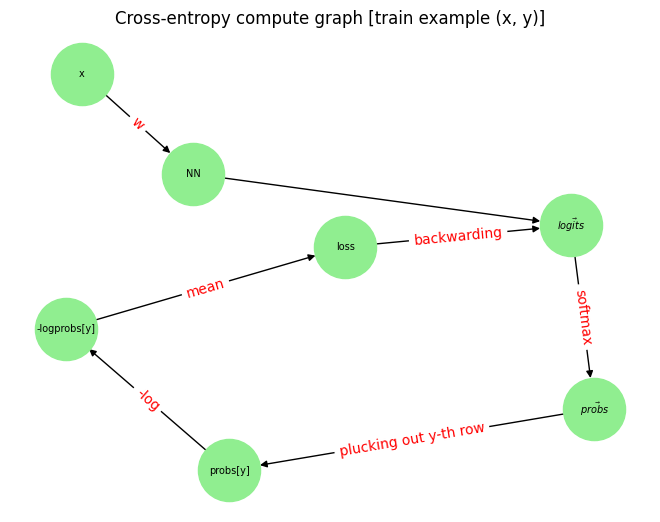

In [16]:
# Specifying the nodes and edges
adjacency = {
    'x': ['NN'],
    'NN': [r'$\vec{logits}$'],
    r'$\vec{logits}$': [r'$\vec{probs}$'],
    r'$\vec{probs}$': ['probs[y]'],
    'probs[y]': ['-logprobs[y]'],
    '-logprobs[y]': ['loss'],
    'loss': [r'$\vec{logits}$']
}
# Creating the graph
G = nx.DiGraph(adjacency)
# Defining the graph layout
pos = nx.spring_layout(G, seed=42)
# Drawing the graph
nx.draw(
    G, 
    pos, 
    ax = None, 
    with_labels = True, 
    font_size = 7, 
    node_size = 2000, 
    node_color = 'lightgreen'
)
# Specifying the graph edge labels
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={
        (r'$\vec{logits}$', r'$\vec{probs}$'): 'softmax',
        ('probs[y]', '-logprobs[y]'): '-log',
        (r'$\vec{probs}$', 'probs[y]'): 'plucking out y-th row',
        ('x', 'NN'): 'w',
        ('loss', r'$\vec{logits}$'): 'backwarding',
        ('-logprobs[y]', 'loss'): 'mean'
    },
    font_color='red'
)
plt.title("Cross-entropy compute graph [train example (x, y)]")
plt.show()

Basically what is happening is that each example $x$ gets fed into the neural net which computes the logits. Next, softmax function transforms the logits into probabilities summing up to one. Then, using information on the correct answers, we pluck out a specific probability with index $y$. Afterwards, we compose negative log-probabilities for each training example/answer which are converted to a single number (loss) using mean function. This is what happens in the forward pass, but then we need to compute the gradient of the loss with respect to logits (backward pass). 

In other words, the focus of this exercise is to find a way to fastly go backward directly from loss to logits (computing `dloss/dlogits`). Firstly, consider what is the loss for one single example $y$:

$$loss = -\log(P_y)$$

The probability in the brackets is the softmax probability taken from logits:

$$P_i = \frac{e^{l_i}}{\sum_{j} e^{l_j}}$$

Now the loss can be written down as follows:

$$loss = -\log\left(\frac{e^{l_y}}{\sum_{j} e^{l_j}}\right)$$

Hence, the task is to find the derivative of this function with respect to each logit:

$$\frac{\partial{loss}}{\partial{l_i}} = \frac{\partial}{\partial{l_i}} \left[ -\log\left(\frac{e^{l_y}}{\sum_{j} e^{l_j}}\right) \right]$$

$$\Downarrow$$

$$\frac{\partial{loss}}{\partial{l_i}} = -\frac{\sum_{j} e^{l_j}}{e^{l_y}} \cdot \frac{\partial}{\partial{l_i}} \left[\frac{e^{l_y}}{\sum_{j} e^{l_j}} \right]$$

Depending on the value of $i$, there two possible situations.

## `i != y`

$$\frac{\partial{loss}}{\partial{l_i}} = -\frac{\sum_{j} e^{l_j}}{e^{l_y}} \cdot \frac{\partial}{\partial{l_i}} \left[\frac{e^{l_y}}{\sum_{j} e^{l_j}} \right]$$

$$\frac{\partial{loss}}{\partial{l_i}} = -\frac{\sum_{j} e^{l_j}}{e^{l_y}} \cdot \left[\frac{0 \cdot \sum_{j} e^{l_j} - e^{l_y} e^{l_i}}{\left(\sum_{j} e^{l_j}\right)^2} \right]$$

$$\frac{\partial{loss}}{\partial{l_i}} = \frac{\sum_{j} e^{l_j}}{e^{l_y}} \cdot \left[\frac{e^{l_y} e^{l_i}}{\left(\sum_{j} e^{l_j}\right)^2} \right] = \frac{e^{l_i}}{\sum_{j} e^{l_j}} = P_i$$

## `i == y`

$$\frac{\partial{loss}}{\partial{l_i}} = -\frac{\sum_{j} e^{l_j}}{e^{l_y}} \cdot \frac{\partial}{\partial{l_i}} \left[\frac{e^{l_y}}{\sum_{j} e^{l_j}} \right]$$

$$\frac{\partial{loss}}{\partial{l_i}} = -\frac{\sum_{j} e^{l_j}}{e^{l_y}} \cdot \left[\frac{e^{l_y} \cdot \sum_{j} e^{l_j} - e^{l_y} e^{l_i}}{\left(\sum_{j} e^{l_j}\right)^2} \right]$$

$$\frac{\partial{loss}}{\partial{l_i}} = -\left[\frac{\sum_{j} e^{l_j} - e^{l_i}}{\sum_{j} e^{l_j}} \right]$$

$$\frac{\partial{loss}}{\partial{l_i}} = -\left[1 - \frac{e^{l_i}}{\sum_{j} e^{l_j}} \right] = \frac{e^{l_i}}{\sum_{j} e^{l_j}} - 1 = P_i - 1$$

## Computing the gradient

In other words, summarizing the results of the above calculation we have to subtract one from the softmax probabilities in a column indexed by the correct answer. At the end, we still need to scale the result down by `n` due to mean.

In [17]:
# Obtaining probabilities
dlogits = F.softmax(logits, 1)

# Subtracting 1 for correct answers
dlogits[range(n), Yb] -= 1

# Scaling down due to mean
dlogits /= n

# Comparing the gradient computed
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 4.889443516731262e-09


In [18]:
logits.grad[:3]

tensor([[ 0.0023,  0.0027,  0.0005,  0.0015,  0.0006,  0.0025,  0.0007,  0.0012,
         -0.0307,  0.0010,  0.0012,  0.0012,  0.0012,  0.0009,  0.0011,  0.0004,
          0.0003,  0.0007,  0.0005,  0.0017,  0.0016,  0.0006,  0.0008,  0.0021,
          0.0018,  0.0008,  0.0007],
        [ 0.0017,  0.0017,  0.0028,  0.0016,  0.0010,  0.0011,  0.0006,  0.0015,
          0.0007,  0.0007,  0.0016,  0.0014,  0.0015,  0.0009, -0.0298,  0.0011,
          0.0009,  0.0006,  0.0006,  0.0013,  0.0006,  0.0007,  0.0005,  0.0018,
          0.0007,  0.0012,  0.0009],
        [ 0.0006,  0.0007,  0.0004,  0.0004,  0.0007,  0.0012,  0.0019,  0.0020,
          0.0020,  0.0009,  0.0006,  0.0011,  0.0014,  0.0015,  0.0007, -0.0304,
          0.0004,  0.0011,  0.0009,  0.0035,  0.0021,  0.0011,  0.0013,  0.0011,
          0.0011,  0.0006,  0.0009]])

In [19]:
dlogits[:3]

tensor([[ 0.0023,  0.0027,  0.0005,  0.0015,  0.0006,  0.0025,  0.0007,  0.0012,
         -0.0307,  0.0010,  0.0012,  0.0012,  0.0012,  0.0009,  0.0011,  0.0004,
          0.0003,  0.0007,  0.0005,  0.0017,  0.0016,  0.0006,  0.0008,  0.0021,
          0.0018,  0.0008,  0.0007],
        [ 0.0017,  0.0017,  0.0028,  0.0016,  0.0010,  0.0011,  0.0006,  0.0015,
          0.0007,  0.0007,  0.0016,  0.0014,  0.0015,  0.0009, -0.0298,  0.0011,
          0.0009,  0.0006,  0.0006,  0.0013,  0.0006,  0.0007,  0.0005,  0.0018,
          0.0007,  0.0012,  0.0009],
        [ 0.0006,  0.0007,  0.0004,  0.0004,  0.0007,  0.0012,  0.0019,  0.0020,
          0.0020,  0.0009,  0.0006,  0.0011,  0.0014,  0.0015,  0.0007, -0.0304,
          0.0004,  0.0011,  0.0009,  0.0035,  0.0021,  0.0011,  0.0013,  0.0011,
          0.0011,  0.0006,  0.0009]], grad_fn=<SliceBackward0>)